# CycleGAN Monet风格转换 - 独立项目

这是一个完整的Kaggle GAN竞赛解决方案，从零开始实现CycleGAN模型。

## 📋 项目特点

- ✅ **完全独立**: 不依赖外部项目
- ✅ **中文注释**: 详细的中文说明
- ✅ **可视化**: 实时查看训练过程和结果
- ✅ **自动保存**: 自动保存模型和样本
- ✅ **一键提交**: 自动生成Kaggle提交文件

## 🚀 使用说明

1. 确保数据已放在 `data/Image_Generation_Data_Kaggle/` 目录
2. 按顺序运行所有cells
3. 训练完成后自动生成提交文件

## 📊 数据说明

- **Monet图像**: 300张Monet原画
- **Photo图像**: 7038张照片
- **格式**: TFRecord文件，256x256像素


## 1. 导入库和设置


In [1]:
# 导入必要的库
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 动态按需分配显存（不会一次性吃满）
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ 已启用 GPU 显存按需分配")
    except RuntimeError as e:
        print(e)

# 设置随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 设置TensorFlow日志级别
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 配置matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 库导入成功！")
print(f"TensorFlow版本: {tf.__version__}")

# 检查GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ 检测到 {len(gpus)} 个GPU")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU配置错误: {e}")
else:
    print("⚠️ 未检测到GPU，将使用CPU（速度会很慢）")


✅ 已启用 GPU 显存按需分配
✅ 库导入成功！
TensorFlow版本: 2.10.1
✅ 检测到 1 个GPU


## 2. 配置参数

**可以根据需要修改以下参数**


In [2]:
# ==================== 配置参数 ====================

# 数据路径
DATA_ROOT = "data/Image_Generation_Data_Kaggle"
MONET_TFREC_PATH = os.path.join(DATA_ROOT, "monet_tfrec")
PHOTO_TFREC_PATH = os.path.join(DATA_ROOT, "photo_tfrec")

# 模型参数
IMAGE_SIZE = 256
CHANNELS = 3
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 0.5

# 训练参数
BATCH_SIZE = 8          # 批次大小（根据显存调整：4/8/16）
EPOCHS = 20             # 训练轮数（推荐：20-50）
LEARNING_RATE = 2e-4    # 学习率
BETA_1 = 0.5            # Adam优化器参数

# 数据增强
USE_AUGMENTATION = True
AUGMENTATION_PROB = 0.5

# 保存设置
SAVE_DIR = "saves"
MODEL_NAME = "cyclegan_monet"
SAVE_SAMPLES = True
NUM_SAMPLES_TO_SAVE = 10

# 打印配置
print("=" * 50)
print("训练配置:")
print("=" * 50)
print(f"数据路径: {DATA_ROOT}")
print(f"图像尺寸: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"批次大小: {BATCH_SIZE}")
print(f"训练轮数: {EPOCHS}")
print(f"学习率: {LEARNING_RATE}")
print(f"Cycle Loss权重: {LAMBDA_CYCLE}")
print(f"使用数据增强: {USE_AUGMENTATION}")
print("=" * 50)


训练配置:
数据路径: data/Image_Generation_Data_Kaggle
图像尺寸: 256x256
批次大小: 8
训练轮数: 20
学习率: 0.0002
Cycle Loss权重: 10.0
使用数据增强: True


## 3. 数据加载函数


In [3]:
import re

def count_data_items(filenames):
    """计算TFRecord文件中的数据项数量"""
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def decode_image(image):
    """解码JPEG图像并归一化到[-1, 1]"""
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
    return image

def read_tfrecord(example):
    """读取TFRecord示例"""
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    """从TFRecord文件加载数据集"""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def augment_image(image):
    """数据增强"""
    if not USE_AUGMENTATION:
        return image
    
    # 随机水平翻转
    image = tf.image.random_flip_left_right(image)
    
    # 随机垂直翻转
    image = tf.image.random_flip_up_down(image)
    
    # 随机旋转（90度倍数）
    if tf.random.uniform([]) < AUGMENTATION_PROB:
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
    
    return image

print("✅ 数据加载函数定义完成")


✅ 数据加载函数定义完成


## 4. 加载数据


In [4]:
# 获取文件列表
monet_files = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, "*.tfrec"))
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, "*.tfrec"))

print(f"找到 {len(monet_files)} 个Monet TFRecord文件")
print(f"找到 {len(photo_files)} 个Photo TFRecord文件")

# 计算数据项数量
n_monet = count_data_items(monet_files)
n_photo = count_data_items(photo_files)

print(f"Monet图像数量: {n_monet}")
print(f"Photo图像数量: {n_photo}")

# 加载数据集
monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)

# 应用数据增强
monet_ds = monet_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# 配置数据集
monet_ds = monet_ds.shuffle(1000).repeat().batch(BATCH_SIZE, drop_remainder=True)
photo_ds = photo_ds.shuffle(1000).repeat().batch(BATCH_SIZE, drop_remainder=True)

# 缓存和预取
monet_ds = monet_ds.cache().prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.cache().prefetch(tf.data.AUTOTUNE)

# 创建配对数据集
dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

print("✅ 数据加载完成")


找到 5 个Monet TFRecord文件
找到 20 个Photo TFRecord文件
Monet图像数量: 300
Photo图像数量: 7038
✅ 数据加载完成


## 5. 可视化数据样本


Monet样本:


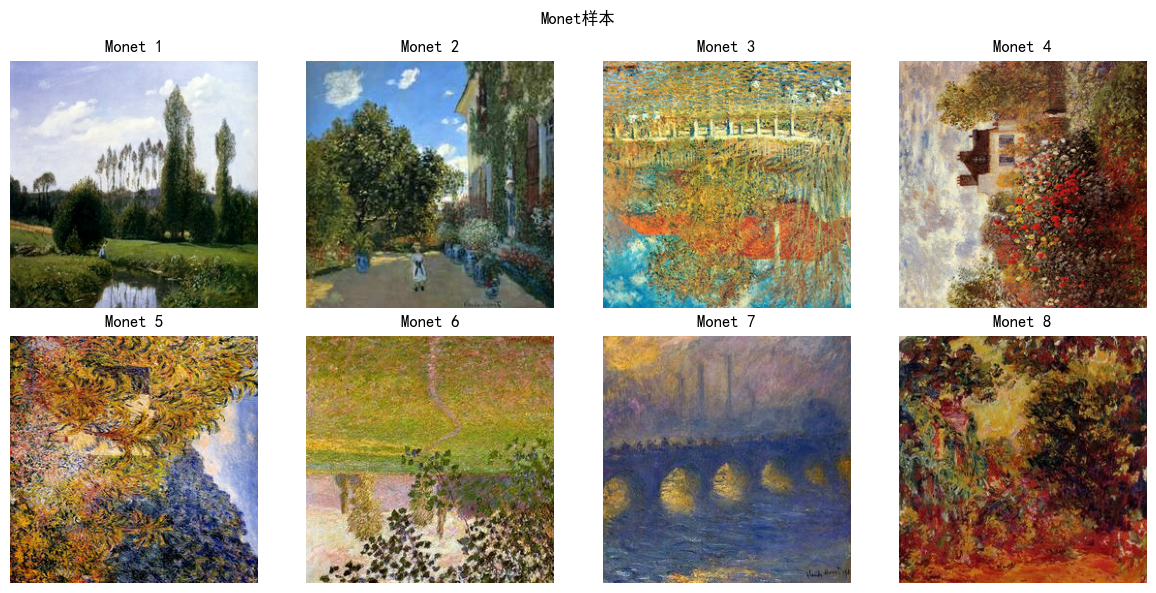

Photo样本:


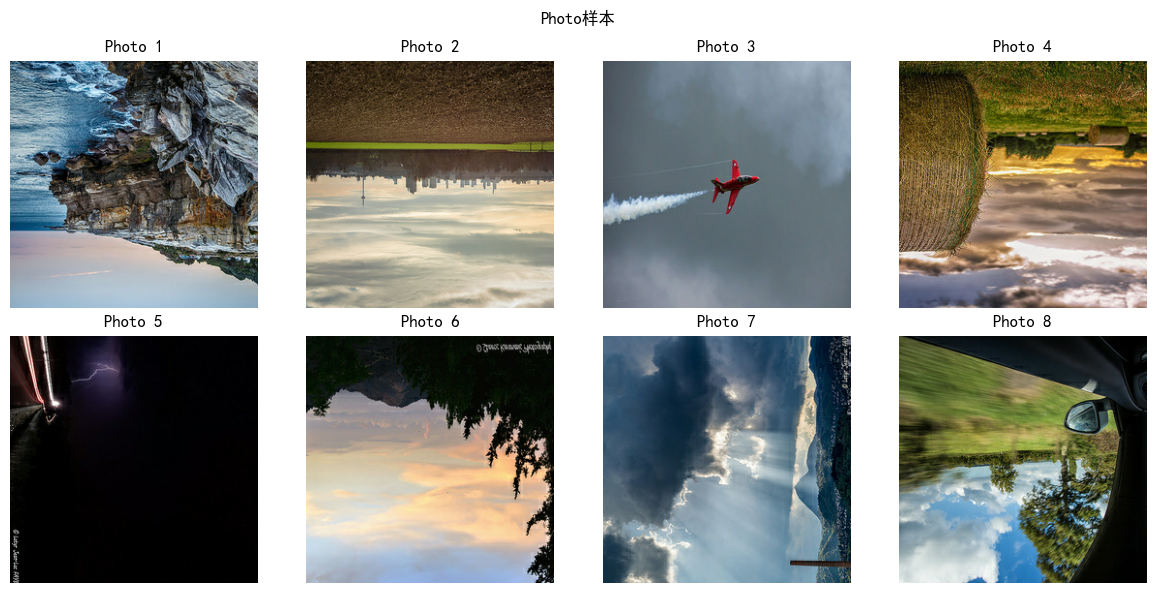

In [5]:
# 显示Monet样本
print("Monet样本:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i, (monet, photo) in enumerate(dataset.take(8)):
    axes[i].imshow(monet[0] * 0.5 + 0.5)
    axes[i].set_title(f'Monet {i+1}')
    axes[i].axis('off')

plt.suptitle('Monet样本')
plt.tight_layout()
plt.show()

# 显示Photo样本
print("Photo样本:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i, (monet, photo) in enumerate(dataset.take(8)):
    axes[i].imshow(photo[0] * 0.5 + 0.5)
    axes[i].set_title(f'Photo {i+1}')
    axes[i].axis('off')

plt.suptitle('Photo样本')
plt.tight_layout()
plt.show()


## 6. 模型定义


In [6]:
import tensorflow as tf

def InstanceNorm():
    """自定义 InstanceNormalization 替代版"""
    # 直接用 LayerNormalization 近似替代（对每个样本独立归一化）
    return tf.keras.layers.LayerNormalization(axis=[1, 2], epsilon=1e-5)

def downsample(filters, size, apply_instancenorm=True, strides=2):
    """下采样层"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                                     kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNorm())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    """上采样层"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                              kernel_initializer=initializer, use_bias=False))

    result.add(InstanceNorm())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def Generator():
    """生成器（U-Net架构）"""
    inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    """判别器（PatchGAN架构）"""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)

    norm1 = InstanceNorm()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

print("✅ 模型定义完成（无需 tensorflow_addons）")



✅ 模型定义完成（无需 tensorflow_addons）


In [7]:
# 创建模型
print("🏗️ 创建模型...")
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

print(f"生成器参数量: {monet_generator.count_params():,}")
print(f"判别器参数量: {monet_discriminator.count_params():,}")

print("✅ 模型创建完成")


🏗️ 创建模型...
生成器参数量: 54,458,709
判别器参数量: 2,775,939
✅ 模型创建完成


## 8. 损失函数定义


In [8]:
def discriminator_loss(real, generated):
    """判别器损失函数"""
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    """生成器损失函数"""
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    """循环一致性损失"""
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    """恒等损失"""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

print("✅ 损失函数定义完成")


✅ 损失函数定义完成


## 9. CycleGAN模型类


In [9]:
class CycleGAN(tf.keras.Model):
    """CycleGAN模型"""
    
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10.0):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_monet)[0]
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo -> Monet -> Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet -> Photo -> Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Identity loss
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle consistency loss
            total_cycle_loss = (self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + 
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle))

            # Identity loss
            total_monet_gen_loss = (monet_gen_loss + total_cycle_loss + 
                                   self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle))
            total_photo_gen_loss = (photo_gen_loss + total_cycle_loss + 
                                   self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle))

            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss,
            'total_cycle_loss': total_cycle_loss
        }

print("✅ CycleGAN模型类定义完成")


✅ CycleGAN模型类定义完成


## 10. 创建优化器和编译模型


In [10]:
# 创建优化器
print("⚙️ 配置优化器...")
monet_gen_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
photo_gen_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
monet_disc_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
photo_disc_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

# 创建CycleGAN模型
cyclegan = CycleGAN(
    monet_generator=monet_generator,
    photo_generator=photo_generator,
    monet_discriminator=monet_discriminator,
    photo_discriminator=photo_discriminator,
    lambda_cycle=LAMBDA_CYCLE
)

# 编译模型
cyclegan.compile(
    m_gen_optimizer=monet_gen_optimizer,
    p_gen_optimizer=photo_gen_optimizer,
    m_disc_optimizer=monet_disc_optimizer,
    p_disc_optimizer=photo_disc_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

print("✅ 模型编译完成")


⚙️ 配置优化器...
✅ 模型编译完成


## 11. 开始训练

**训练可能需要较长时间，请耐心等待**


In [11]:
# 创建保存目录
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join(SAVE_DIR, f"{MODEL_NAME}_{timestamp}")
os.makedirs(save_dir, exist_ok=True)
print(f"模型将保存到: {save_dir}")

# 计算训练步数
steps_per_epoch = max(n_monet, n_photo) // BATCH_SIZE
print(f"每轮步数: {steps_per_epoch}")
print(f"总步数: {steps_per_epoch * EPOCHS}")

# 创建回调
class LogCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_interval=50):
        super().__init__()
        self.log_interval = log_interval
    
    def on_batch_end(self, batch, logs=None):
        if batch % self.log_interval == 0:
            print(f"Batch {batch}: "
              f"Monet Gen Loss: {np.mean(logs['monet_gen_loss']):.4f}, "
              f"Photo Gen Loss: {np.mean(logs['photo_gen_loss']):.4f}, "
              f"Monet Disc Loss: {np.mean(logs['monet_disc_loss']):.4f}, "
              f"Photo Disc Loss: {np.mean(logs['photo_disc_loss']):.4f}, "
              f"Cycle Loss: {np.mean(logs['total_cycle_loss']):.4f})")



callbacks = [
    LogCallback(log_interval=50),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, "checkpoint.weights.h5"),
        save_weights_only=True,
        save_best_only=False,
        verbose=1
    )
]

# 开始训练
print("🚀 开始训练...")
print("=" * 50)

history = cyclegan.fit(
    dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

print("✅ 训练完成！")


模型将保存到: saves\cyclegan_monet_20251027_200829
每轮步数: 879
总步数: 17580
🚀 开始训练...
Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_1/conv2d_transpose_15/conv2d_transpose_2/Conv2D' defined at (most recent call last):
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 602, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MisterBi\AppData\Local\Temp\ipykernel_2624\3862220208.py", line 43, in <module>
      history = cyclegan.fit(
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\MisterBi\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\MisterBi\AppData\Local\Temp\ipykernel_2624\3067081545.py", line 68, in train_step
      photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
Node: 'gradient_tape/model_1/conv2d_transpose_15/conv2d_transpose_2/Conv2D'
OOM when allocating tensor with shape[8,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_1/conv2d_transpose_15/conv2d_transpose_2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_36002]

In [ ]:
# 创建保存目录
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join(SAVE_DIR, f"{MODEL_NAME}_{timestamp}")
os.makedirs(save_dir, exist_ok=True)
print(f"模型将保存到: {save_dir}")

# 计算训练步数
steps_per_epoch = max(n_monet, n_photo) // BATCH_SIZE
print(f"每轮步数: {steps_per_epoch}")
print(f"总步数: {steps_per_epoch * EPOCHS}")

# 检查GPU状态
gpus = tf.config.list_physical_devices('GPU')
USE_GPU = len(gpus) > 0

# 修复后的回调函数
class LogCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_interval=50):
        super().__init__()
        self.log_interval = log_interval
        self.batch_count = 0
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.log_interval == 0:
            if logs:
                monet_gen = logs.get('monet_gen_loss', 0)
                photo_gen = logs.get('photo_gen_loss', 0)
                monet_disc = logs.get('monet_disc_loss', 0)
                photo_disc = logs.get('photo_disc_loss', 0)
                cycle = logs.get('total_cycle_loss', 0)
                
                print(f"\nBatch {self.batch_count}: "
                      f"MG={monet_gen:.4f}, PG={photo_gen:.4f}, "
                      f"MD={monet_disc:.4f}, PD={photo_disc:.4f}, Cyc={cycle:.4f}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{EPOCHS} 完成")
        if logs:
            for key, value in logs.items():
                print(f"  {key}: {value:.4f}")
        print(f"{'='*60}\n")

# 自定义保存回调 - 适配你的模型结构
class SafeModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, save_freq='epoch'):
        super().__init__()
        self.save_dir = save_dir
        self.save_freq = save_freq
        self.epoch_count = 0
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        try:
            # 尝试不同的属性名称
            if hasattr(self.model, 'monet_generator'):
                monet_gen = self.model.monet_generator
                photo_gen = self.model.photo_generator
            elif hasattr(self.model, 'm_gen'):
                monet_gen = self.model.m_gen
                photo_gen = self.model.p_gen
            elif hasattr(self.model, 'gen_G'):
                monet_gen = self.model.gen_G
                photo_gen = self.model.gen_F
            else:
                # 如果找不到，尝试保存整个模型
                model_path = os.path.join(self.save_dir, f'cyclegan_epoch{self.epoch_count}.h5')
                self.model.save_weights(model_path)
                print(f"✅ Epoch {self.epoch_count} 完整模型已保存")
                return
            
            monet_gen_path = os.path.join(self.save_dir, f'monet_gen_epoch{self.epoch_count}.h5')
            photo_gen_path = os.path.join(self.save_dir, f'photo_gen_epoch{self.epoch_count}.h5')
            
            monet_gen.save_weights(monet_gen_path)
            photo_gen.save_weights(photo_gen_path)
            print(f"✅ Epoch {self.epoch_count} 生成器已保存")
        except Exception as e:
            print(f"⚠️ 保存失败: {e}")

# 构建模型（适配不同的模型结构）
print("\n构建模型...")
try:
    sample_monet = next(iter(monet_ds.take(1)))
    sample_photo = next(iter(photo_ds.take(1)))
    
    # 尝试不同的属性访问方式
    if hasattr(cyclegan, 'monet_generator'):
        _ = cyclegan.monet_generator(sample_photo, training=False)
        _ = cyclegan.photo_generator(sample_monet, training=False)
        _ = cyclegan.monet_discriminator(sample_monet, training=False)
        _ = cyclegan.photo_discriminator(sample_photo, training=False)
    elif hasattr(cyclegan, 'm_gen'):
        _ = cyclegan.m_gen(sample_photo, training=False)
        _ = cyclegan.p_gen(sample_monet, training=False)
        _ = cyclegan.m_disc(sample_monet, training=False)
        _ = cyclegan.p_disc(sample_photo, training=False)
    else:
        # 直接调用模型
        _ = cyclegan((sample_monet, sample_photo), training=False)
    
    print("✅ 模型构建成功")
except Exception as e:
    print(f"⚠️ 构建警告: {e}")
    print("模型将在训练时自动构建")

# 创建回调
callbacks = [
    LogCallback(log_interval=50),
    SafeModelCheckpoint(save_dir=save_dir),
]

# 开始训练
print("\n" + "="*70)
print("🚀 开始训练...")
print("="*70)
print(f"设备: {'GPU' if USE_GPU else 'CPU'}")
print(f"图像: {IMAGE_SIZE}x{IMAGE_SIZE}, Batch: {BATCH_SIZE}")
print(f"步数: {steps_per_epoch}/epoch, 总计: {steps_per_epoch * EPOCHS}")
print("="*70 + "\n")

try:
    history = cyclegan.fit(
        dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callbacks
    )
    
    print("\n" + "="*70)
    print("✅ 训练完成！")
    print("="*70)
    
    # 保存最终模型 - 适配不同结构
    try:
        if hasattr(cyclegan, 'monet_generator'):
            final_monet = os.path.join(save_dir, 'monet_generator_final.h5')
            final_photo = os.path.join(save_dir, 'photo_generator_final.h5')
            cyclegan.monet_generator.save_weights(final_monet)
            cyclegan.photo_generator.save_weights(final_photo)
        else:
            # 保存整个模型
            final_model = os.path.join(save_dir, 'cyclegan_final.h5')
            cyclegan.save_weights(final_model)
        print(f"✅ 最终模型已保存: {save_dir}")
    except Exception as e:
        print(f"⚠️ 保存最终模型失败: {e}")
    
    # 保存历史
    try:
        with open(os.path.join(save_dir, 'history.pkl'), 'wb') as f:
            pickle.dump(history.history, f)
        print(f"✅ 训练历史已保存")
    except:
        pass
    
except KeyboardInterrupt:
    print("\n⚠️ 训练中断，保存当前模型...")
    try:
        cyclegan.save_weights(os.path.join(save_dir, 'cyclegan_interrupted.h5'))
        print("✅ 已保存")
    except Exception as e:
        print(f"⚠️ 保存失败: {e}")
    
except Exception as e:
    print(f"\n❌ 训练出错: {e}")
    import traceback
    traceback.print_exc()

print("\n训练脚本完成")

## 12. 可视化训练历史


In [ ]:
# 绘制训练历史
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Generator Loss
axes[0, 0].plot(history.history['monet_gen_loss'], label='Monet Gen')
axes[0, 0].plot(history.history['photo_gen_loss'], label='Photo Gen')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Discriminator Loss
axes[0, 1].plot(history.history['monet_disc_loss'], label='Monet Disc')
axes[0, 1].plot(history.history['photo_disc_loss'], label='Photo Disc')
axes[0, 1].set_title('Discriminator Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Cycle Loss
axes[1, 0].plot(history.history['total_cycle_loss'], label='Cycle Loss')
axes[1, 0].set_title('Cycle Consistency Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Combined Loss
axes[1, 1].plot(history.history['monet_gen_loss'], label='Monet Gen')
axes[1, 1].plot(history.history['photo_gen_loss'], label='Photo Gen')
axes[1, 1].plot(history.history['monet_disc_loss'], label='Monet Disc')
axes[1, 1].plot(history.history['photo_disc_loss'], label='Photo Disc')
axes[1, 1].set_title('All Losses')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## 13. 显示生成结果


In [ ]:
# 显示生成的样本
print("🎨 显示生成样本...")
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

photo_dataset = dataset.map(lambda x, y: y)  # 提取photo部分

for i, photo in enumerate(photo_dataset.take(8)):
    # 原始照片
    axes[0, i].imshow(photo[0] * 0.5 + 0.5)
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # 生成的Monet风格
    generated = monet_generator(photo, training=False)
    axes[1, i].imshow(generated[0] * 0.5 + 0.5)
    axes[1, i].set_title(f'Generated {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Photo to Monet Style Transfer')
plt.tight_layout()
plt.show()


## 14. 保存模型


In [ ]:
# 保存模型
print("💾 保存模型...")
monet_generator.save(os.path.join(save_dir, "monet_generator.h5"))
photo_generator.save(os.path.join(save_dir, "photo_generator.h5"))
monet_discriminator.save(os.path.join(save_dir, "monet_discriminator.h5"))
photo_discriminator.save(os.path.join(save_dir, "photo_discriminator.h5"))

print("✅ 模型保存完成")
print(f"模型保存路径: {save_dir}")


## 15. 生成提交文件


In [ ]:
from PIL import Image
import shutil

# 创建预测数据集（单张图像批次）
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, "*.tfrec"))
photo_ds_predict = load_dataset(photo_files)
photo_ds_predict = photo_ds_predict.batch(1)  # 单张图像批次

# 创建输出目录
output_dir = os.path.join(save_dir, "submission_images")
os.makedirs(output_dir, exist_ok=True)

# 生成图像
print("🎨 生成提交图像...")
count = 0

for photo in photo_ds_predict:
    # 生成Monet风格图像
    generated = monet_generator(photo, training=False)
    
    # 转换为PIL图像并保存
    img_array = (generated[0].numpy() * 127.5 + 127.5).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(os.path.join(output_dir, f'{count+1}.jpg'))
    
    count += 1
    
    if count % 100 == 0:
        print(f"已生成 {count} 张图像")

print(f"总共生成了 {count} 张图像")

# 创建ZIP文件
zip_path = shutil.make_archive(output_dir, 'zip', output_dir)
zip_size = os.path.getsize(zip_path) / (1024 * 1024)

print(f"ZIP文件已创建: {zip_path}")
print(f"文件大小: {zip_size:.2f} MB")

# 验证结果
if count < 7000:
    print("⚠️ 警告: 图像数量少于7000张！")
elif count > 10000:
    print("⚠️ 警告: 图像数量超过10000张！")
else:
    print("✅ 图像数量符合要求 (7000-10000张)")

print(f"\n🎉 提交文件已生成: {zip_path}")
print("请将此文件上传到Kaggle竞赛页面")


## 完成！

你的CycleGAN模型已经训练完成，提交文件已生成！

### 📊 训练总结

- ✅ 模型训练完成
- ✅ 训练历史已可视化
- ✅ 生成样本已展示
- ✅ 模型已保存
- ✅ 提交文件已生成

### 🎯 下一步

1. 找到生成的ZIP文件（在saves目录下）
2. 上传到Kaggle竞赛页面
3. 等待评估结果

### 💡 优化建议

- 如果想获得更好的效果，可以增加训练轮数（EPOCHS）
- 可以尝试不同的超参数组合
- 可以添加更多的数据增强技术

### 📁 文件说明

- `monet_generator.h5`: 训练好的Monet生成器
- `submission_images.zip`: Kaggle提交文件
- `checkpoint.h5`: 训练检查点

**祝你竞赛成功！** 🎨🏆
